In [1]:
import numpy as np
from scipy.io import wavfile
import soundfile as sf

# Load the stereo WAV file
sample_rate, audio_data = wavfile.read('english_long.wav')

# Check if the audio is stereo (has 2 channels)
if len(audio_data.shape) == 2 and audio_data.shape[1] == 2:
    # Extract left channel (channel 1)
    left_channel = audio_data[:, 0]
    
    # Extract right channel (channel 2)
    right_channel = audio_data[:, 1]
    
    # Save left channel as english_long_ch1.wav
    wavfile.write('english_long_ch1.wav', sample_rate, left_channel)
    
    # Save right channel as english_long_ch2.wav
    wavfile.write('english_long_ch2.wav', sample_rate, right_channel)
    
    print("Successfully saved both channels as separate files.")
else:
    print("The input file is not stereo. Please check the audio file.")


FileNotFoundError: [Errno 2] No such file or directory: 'english_long.wav'

NameError: name 'apple' is not defined

# Debugging

In [1]:
import argparse
import torch
from whisperx.utils import LANGUAGES, TO_LANGUAGE_CODE, optional_float, optional_int, str2bool

# Create an argument parser with default values
parser = argparse.ArgumentParser(formatter_class=argparse.ArgumentDefaultsHelpFormatter)
parser.add_argument("audio", nargs="+", type=str, help="audio file(s) to transcribe")
parser.add_argument("--model", default="openai/whisper-large-v3", help="name of the Whisper model to use")
parser.add_argument("--model_cache_only", type=str2bool, default=False, help="If True, will not attempt to download models, instead using cached models from --model_dir")
parser.add_argument("--model_dir", type=str, default=None, help="the path to save model files; uses ~/.cache/whisper by default")
parser.add_argument("--device", default="cuda" if torch.cuda.is_available() else "cpu", help="device to use for PyTorch inference")
parser.add_argument("--device_index", default=0, type=int, help="device index to use for FasterWhisper inference")
parser.add_argument("--batch_size", default=4, type=int, help="the preferred batch size for inference")
parser.add_argument("--compute_type", default="float16", type=str, choices=["float16", "float32", "int8"], help="compute type for computation")
parser.add_argument("--use_openai_whisper", type=str2bool, default=False, help="use OpenAI Whisper from Hugging Face instead of Faster Whisper")

parser.add_argument("--output_dir", "-o", type=str, default=".", help="directory to save the outputs")
parser.add_argument("--output_format", "-f", type=str, default="all", choices=["all", "srt", "vtt", "txt", "tsv", "json", "aud"], help="format of the output file; if not specified, all available formats will be produced")
parser.add_argument("--verbose", type=str2bool, default=None, help="whether to print out the progress and debug messages")

parser.add_argument("--task", type=str, default="transcribe", choices=["transcribe", "translate"], help="whether to perform X->X speech recognition ('transcribe') or X->English translation ('translate')")
parser.add_argument("--language", type=str, default=None, choices=sorted(LANGUAGES.keys()) + sorted([k.title() for k in TO_LANGUAGE_CODE.keys()]), help="language spoken in the audio, specify None to perform language detection")

# alignment params
parser.add_argument("--align_model", default=None, help="Name of phoneme-level ASR model to do alignment")
parser.add_argument("--interpolate_method", default="nearest", choices=["nearest", "linear", "ignore"], help="For word .srt, method to assign timestamps to non-aligned words, or merge them into neighbouring.")
parser.add_argument("--no_align", action='store_true', help="Do not perform phoneme alignment")
parser.add_argument("--return_char_alignments", action='store_true', help="Return character-level alignments in the output json file")

# vad params
parser.add_argument("--vad_method", type=str, default="silero_custom", choices=["pyannote", "silero", "silero_custom"], help="VAD method to be used")
parser.add_argument("--vad_onset", type=float, default=0.500, help="Onset threshold for VAD (see pyannote.audio), reduce this if speech is not being detected")
parser.add_argument("--vad_offset", type=float, default=0.363, help="Offset threshold for VAD (see pyannote.audio), reduce this if speech is not being detected.")
parser.add_argument("--chunk_size", type=int, default=30, help="Chunk size for merging VAD segments. Default is 30, reduce this if the chunk is too long.")
parser.add_argument("--vad_onnx", type=str2bool, default=True, help="If `True`, use the ONNX version of the Silero VAD model.")
parser.add_argument("--silero_merge_cutoff", type=float, default=0.1, help="The merge cutoff for the Silero VAD model.")

# diarization params
parser.add_argument("--diarize", action="store_true", help="Apply diarization to assign speaker labels to each segment/word")
parser.add_argument("--min_speakers", default=None, type=int, help="Minimum number of speakers to in audio file")
parser.add_argument("--max_speakers", default=None, type=int, help="Maximum number of speakers to in audio file")

parser.add_argument("--temperature", type=float, default=0, help="temperature to use for sampling")
parser.add_argument("--best_of", type=optional_int, default=5, help="number of candidates when sampling with non-zero temperature")
parser.add_argument("--beam_size", type=optional_int, default=5, help="number of beams in beam search, only applicable when temperature is zero")
parser.add_argument("--patience", type=float, default=1.0, help="optional patience value to use in beam decoding, as in https://arxiv.org/abs/2204.05424, the default (1.0) is equivalent to conventional beam search")
parser.add_argument("--length_penalty", type=float, default=1.0, help="optional token length penalty coefficient (alpha) as in https://arxiv.org/abs/1609.08144, uses simple length normalization by default")

parser.add_argument("--suppress_tokens", type=str, default="-1", help="comma-separated list of token ids to suppress during sampling; '-1' will suppress most special characters except common punctuations")
parser.add_argument("--suppress_numerals", action="store_true", help="whether to suppress numeric symbols and currency symbols during sampling, since wav2vec2 cannot align them correctly")

parser.add_argument("--initial_prompt", type=str, default=None, help="optional text to provide as a prompt for the first window.")
parser.add_argument("--condition_on_previous_text", type=str2bool, default=False, help="if True, provide the previous output of the model as a prompt for the next window; disabling may make the text inconsistent across windows, but the model becomes less prone to getting stuck in a failure loop")
parser.add_argument("--fp16", type=str2bool, default=True, help="whether to perform inference in fp16; True by default")

parser.add_argument("--temperature_increment_on_fallback", type=optional_float, default=0.2, help="temperature to increase when falling back when the decoding fails to meet either of the thresholds below")
parser.add_argument("--compression_ratio_threshold", type=optional_float, default=2.4, help="if the gzip compression ratio is higher than this value, treat the decoding as failed")
parser.add_argument("--logprob_threshold", type=optional_float, default=-1.0, help="if the average log probability is lower than this value, treat the decoding as failed")
parser.add_argument("--no_speech_threshold", type=optional_float, default=0.6, help="if the probability of the <|nospeech|> token is higher than this value AND the decoding has failed due to `logprob_threshold`, consider the segment as silence")

parser.add_argument("--max_line_width", type=optional_int, default=None, help="(not possible with --no_align) the maximum number of characters in a line before breaking the line")
parser.add_argument("--max_line_count", type=optional_int, default=None, help="(not possible with --no_align) the maximum number of lines in a segment")
parser.add_argument("--highlight_words", type=str2bool, default=False, help="(not possible with --no_align) underline each word as it is spoken in srt and vtt")
parser.add_argument("--segment_resolution", type=str, default="sentence", choices=["sentence", "chunk"], help="(not possible with --no_align) the maximum number of characters in a line before breaking the line")

parser.add_argument("--threads", type=optional_int, default=0, help="number of threads used by torch for CPU inference; supercedes MKL_NUM_THREADS/OMP_NUM_THREADS")

parser.add_argument("--hf_token", type=str, default=None, help="Hugging Face Access Token to access PyAnnote gated models")

parser.add_argument("--print_progress", type=str2bool, default=False, help="if True, progress will be printed in transcribe() and align() methods.")

# Create an args object with default values
args = parser.parse_args(['english_long_ch1.wav'])  # Default audio file

# Override with specific values if needed
args.model = "openai/whisper-large-v3"
args.device = "cuda" if torch.cuda.is_available() else "cpu"
args.use_openai_whisper = True
args.compute_type = "float16"
args.language = "en"
args.verbose = True

model_name: str = args.model
batch_size: int = args.batch_size
model_dir: str = args.model_dir
model_cache_only: bool = args.model_cache_only
output_dir: str = args.output_dir
output_format: str = args.output_format
device: str = args.device
device_index: int = args.device_index
compute_type: str = args.compute_type
verbose: bool = args.verbose
use_openai_whisper: bool = args.use_openai_whisper

/opt/conda/envs/whisper-smart/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
asr_options = {
    "beam_size": args.beam_size,
    "patience": args.patience,
    "length_penalty": args.length_penalty,
    "suppress_tokens": [int(x) for x in args.suppress_tokens.split(",")],
    "suppress_numerals": args.suppress_numerals,
}


hf_token: str = args.hf_token
vad_method: str = args.vad_method
vad_onset: float = args.vad_onset
vad_offset: float = args.vad_offset
chunk_size: int = args.chunk_size

diarize: bool = args.diarize
min_speakers: int = args.min_speakers
max_speakers: int = args.max_speakers
print_progress: bool = args.print_progress
task = args.task


In [3]:
device = "cuda:0"

In [4]:
from whisperx.transcribe import *

model = load_openai_model(
    model_name, 
    device=device, 
    device_index=device_index, 
    download_root=model_dir, 
    compute_type=compute_type, 
    language=None,
    asr_options=asr_options, 
    vad_method=vad_method, 
    vad_options={"chunk_size":chunk_size, "vad_onset": vad_onset, "vad_offset": vad_offset}, 
    task=task,
    local_files_only=model_cache_only,
    return_token_probabilities=use_openai_whisper
)

>>Performing voice activity detection using Silero...


Using cache found in /home/ubuntu/.cache/torch/hub/snakers4_silero-vad_master


In [5]:
model.device

device(type='cuda', index=0)

In [6]:
from whisperx.asr import *

In [16]:
audio ="examples/english_long_ch1.wav"
# audio ="examples/hindi.wav"
if isinstance(audio, str):
    audio = load_audio(audio)

In [17]:
# Pre-process audio and merge chunks as defined by the respective VAD child class 
# In case vad_model is manually assigned (see 'load_model') follow the functionality of pyannote toolkit
if issubclass(type(model.vad_model), Vad):
    waveform = model.vad_model.preprocess_audio(audio)
    merge_chunks =  model.vad_model.merge_chunks
else:
    waveform = Pyannote.preprocess_audio(audio)
    merge_chunks = Pyannote.merge_chunks

In [18]:
vad_segments = model.vad_model({"waveform": waveform, "sample_rate": SAMPLE_RATE})
vad_segments = merge_chunks(
    vad_segments,
    chunk_size,
    onset=model._vad_params["vad_onset"],
    offset=model._vad_params["vad_offset"],
)

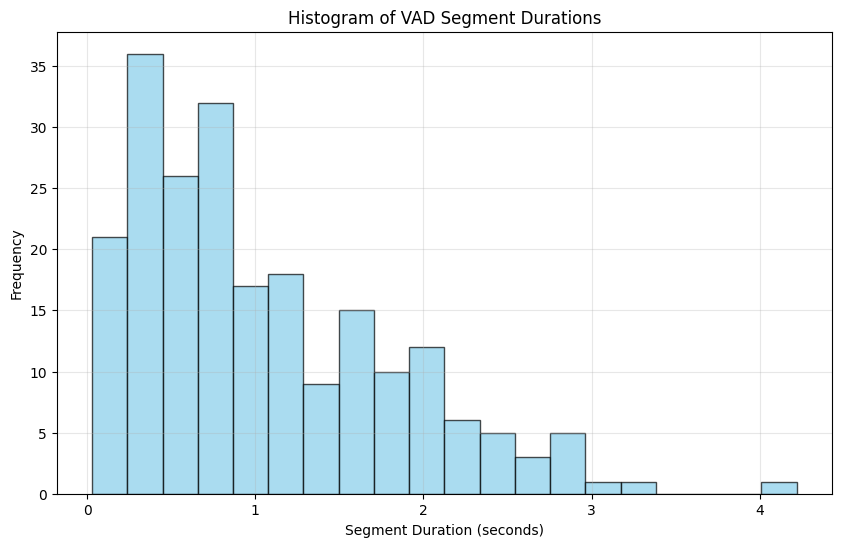

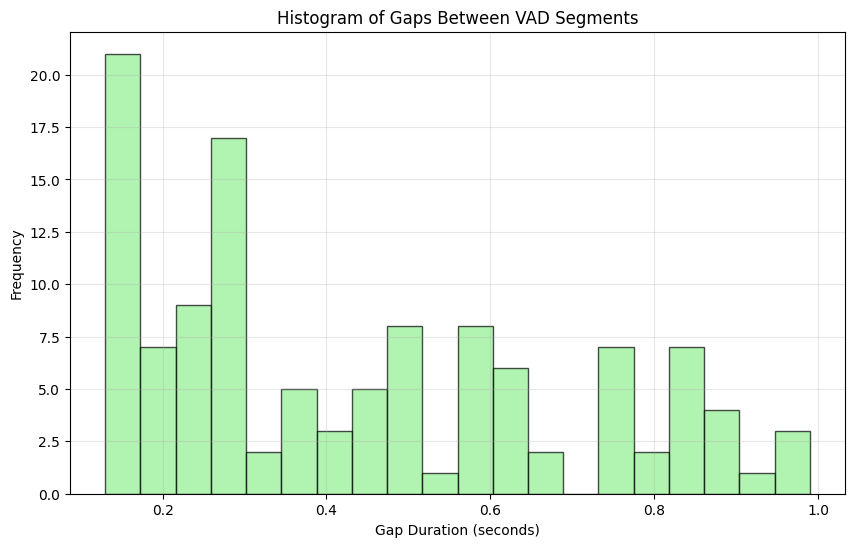

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# Extract segment durations
durations = [round(i["end"]-i["start"], 2) for i in vad_segments]

# Create histogram
plt.figure(figsize=(10, 6))
plt.hist(durations, bins=20, alpha=0.7, color='skyblue', edgecolor='black')
plt.xlabel('Segment Duration (seconds)')
plt.ylabel('Frequency')
plt.title('Histogram of VAD Segment Durations')
plt.grid(alpha=0.3)
plt.show()


# Calculate the time gaps between consecutive segments
gaps = []
for i in range(1, len(vad_segments)):
    current_start = vad_segments[i]["start"]
    previous_end = vad_segments[i-1]["end"]
    gap = round(current_start - previous_end, 2)
    gaps.append(gap)
    
gaps = [i for i in gaps if i < 1]

# Create histogram of gaps between segments
plt.figure(figsize=(10, 6))
plt.hist(gaps, bins=20, alpha=0.7, color='lightgreen', edgecolor='black')
plt.xlabel('Gap Duration (seconds)')
plt.ylabel('Frequency')
plt.title('Histogram of Gaps Between VAD Segments')
plt.grid(alpha=0.3)
plt.show()

In [20]:
from tqdm import tqdm
languages = []
for segment in tqdm(vad_segments):
    start_frame = int(segment['start'] * SAMPLE_RATE)
    end_frame = int(segment['end'] * SAMPLE_RATE)
    audio_segment = audio[start_frame:end_frame]
    languages.append(model.detect_language(audio_segment))

  1%|          | 2/218 [00:00<00:19, 10.97it/s]

Detected language: en (probability: 0.9980)
Detected language: en (probability: 0.9980)


  2%|▏         | 4/218 [00:00<00:19, 10.98it/s]

Detected language: en (probability: 0.9985)
Detected language: en (probability: 0.9990)
Detected language: en (probability: 0.9990)


  4%|▎         | 8/218 [00:00<00:19, 11.00it/s]

Detected language: en (probability: 0.9985)
Detected language: en (probability: 0.9858)
Detected language: en (probability: 1.0000)


  5%|▍         | 10/218 [00:00<00:18, 10.99it/s]

Detected language: en (probability: 0.9912)
Detected language: en (probability: 0.9995)
Detected language: en (probability: 0.8423)


  6%|▋         | 14/218 [00:01<00:18, 10.98it/s]

Detected language: en (probability: 0.9980)
Detected language: en (probability: 0.7866)
Detected language: en (probability: 0.8501)


  7%|▋         | 16/218 [00:01<00:18, 10.98it/s]

Detected language: en (probability: 0.9883)
Detected language: en (probability: 0.7539)
Detected language: en (probability: 0.9990)


  9%|▉         | 20/218 [00:01<00:17, 11.01it/s]

Detected language: en (probability: 0.9990)
Detected language: en (probability: 0.9985)
Detected language: en (probability: 0.9971)


 10%|█         | 22/218 [00:02<00:17, 11.03it/s]

Detected language: en (probability: 0.9932)
Detected language: en (probability: 0.9995)
Detected language: en (probability: 0.9971)


 12%|█▏        | 26/218 [00:02<00:17, 11.05it/s]

Detected language: en (probability: 1.0000)
Detected language: en (probability: 0.9951)
Detected language: en (probability: 0.9932)


 13%|█▎        | 28/218 [00:02<00:17, 11.05it/s]

Detected language: en (probability: 0.9985)
Detected language: en (probability: 0.9995)
Detected language: en (probability: 0.9326)


 15%|█▍        | 32/218 [00:02<00:16, 11.07it/s]

Detected language: en (probability: 0.9976)
Detected language: en (probability: 0.9995)
Detected language: en (probability: 0.9990)


 16%|█▌        | 34/218 [00:03<00:16, 11.07it/s]

Detected language: en (probability: 0.9995)
Detected language: en (probability: 0.9995)
Detected language: en (probability: 0.9995)


 17%|█▋        | 38/218 [00:03<00:16, 11.08it/s]

Detected language: en (probability: 0.9995)
Detected language: en (probability: 0.6201)
Detected language: en (probability: 0.9995)


 18%|█▊        | 40/218 [00:03<00:16, 11.07it/s]

Detected language: en (probability: 1.0000)
Detected language: en (probability: 0.9937)
Detected language: en (probability: 0.9785)


 20%|██        | 44/218 [00:03<00:15, 11.07it/s]

Detected language: en (probability: 0.9980)
Detected language: en (probability: 0.9990)
Detected language: en (probability: 1.0000)


 21%|██        | 46/218 [00:04<00:15, 11.05it/s]

Detected language: en (probability: 0.9995)
Detected language: en (probability: 0.9990)
Detected language: en (probability: 0.4480)


 23%|██▎       | 50/218 [00:04<00:15, 11.06it/s]

Detected language: en (probability: 0.9956)
Detected language: en (probability: 1.0000)
Detected language: en (probability: 0.9995)


 24%|██▍       | 52/218 [00:04<00:15, 11.06it/s]

Detected language: en (probability: 0.9995)
Detected language: en (probability: 1.0000)
Detected language: en (probability: 1.0000)


 26%|██▌       | 56/218 [00:05<00:14, 11.06it/s]

Detected language: en (probability: 0.9990)
Detected language: en (probability: 1.0000)
Detected language: en (probability: 1.0000)


 27%|██▋       | 58/218 [00:05<00:14, 11.07it/s]

Detected language: en (probability: 0.9023)
Detected language: en (probability: 0.9980)
Detected language: en (probability: 0.9976)


 28%|██▊       | 62/218 [00:05<00:14, 11.07it/s]

Detected language: en (probability: 0.9839)
Detected language: en (probability: 0.9990)
Detected language: en (probability: 0.9995)


 29%|██▉       | 64/218 [00:05<00:13, 11.07it/s]

Detected language: en (probability: 0.9990)
Detected language: en (probability: 0.9985)
Detected language: en (probability: 0.9839)


 31%|███       | 68/218 [00:06<00:13, 11.08it/s]

Detected language: en (probability: 0.9995)
Detected language: en (probability: 0.9995)
Detected language: en (probability: 0.9717)


 32%|███▏      | 70/218 [00:06<00:13, 11.08it/s]

Detected language: en (probability: 0.9995)
Detected language: en (probability: 1.0000)
Detected language: en (probability: 0.9985)


 34%|███▍      | 74/218 [00:06<00:12, 11.09it/s]

Detected language: en (probability: 0.9995)
Detected language: en (probability: 0.9990)
Detected language: en (probability: 0.9595)


 35%|███▍      | 76/218 [00:06<00:12, 11.09it/s]

Detected language: en (probability: 0.9990)
Detected language: en (probability: 0.9990)
Detected language: en (probability: 0.9946)


 37%|███▋      | 80/218 [00:07<00:12, 11.08it/s]

Detected language: en (probability: 0.9985)
Detected language: en (probability: 0.7939)
Detected language: en (probability: 0.9995)


 38%|███▊      | 82/218 [00:07<00:12, 11.08it/s]

Detected language: en (probability: 0.9688)
Detected language: en (probability: 1.0000)
Detected language: en (probability: 0.9922)


 39%|███▉      | 86/218 [00:07<00:11, 11.08it/s]

Detected language: en (probability: 0.9976)
Detected language: en (probability: 0.9985)
Detected language: en (probability: 0.9580)


 40%|████      | 88/218 [00:07<00:11, 11.08it/s]

Detected language: en (probability: 0.9995)
Detected language: en (probability: 1.0000)
Detected language: en (probability: 0.9966)


 42%|████▏     | 92/218 [00:08<00:11, 11.07it/s]

Detected language: en (probability: 0.9971)
Detected language: en (probability: 0.9990)
Detected language: en (probability: 0.9980)


 43%|████▎     | 94/218 [00:08<00:11, 11.07it/s]

Detected language: en (probability: 0.3293)
Detected language: en (probability: 0.9995)
Detected language: en (probability: 0.9995)


 45%|████▍     | 98/218 [00:08<00:10, 11.07it/s]

Detected language: en (probability: 0.9990)
Detected language: en (probability: 0.9946)
Detected language: en (probability: 0.9937)


 46%|████▌     | 100/218 [00:09<00:10, 11.05it/s]

Detected language: en (probability: 0.9922)
Detected language: en (probability: 1.0000)
Detected language: en (probability: 0.9985)


 48%|████▊     | 104/218 [00:09<00:10, 11.06it/s]

Detected language: en (probability: 0.9995)
Detected language: en (probability: 0.9814)
Detected language: en (probability: 0.9995)


 49%|████▊     | 106/218 [00:09<00:10, 11.07it/s]

Detected language: en (probability: 0.9995)
Detected language: en (probability: 0.9443)
Detected language: en (probability: 0.8066)


 50%|█████     | 110/218 [00:09<00:09, 11.07it/s]

Detected language: en (probability: 0.3840)
Detected language: en (probability: 0.9932)
Detected language: en (probability: 0.9980)


 51%|█████▏    | 112/218 [00:10<00:09, 11.07it/s]

Detected language: en (probability: 1.0000)
Detected language: en (probability: 0.9536)
Detected language: en (probability: 0.8101)


 53%|█████▎    | 116/218 [00:10<00:09, 11.06it/s]

Detected language: en (probability: 0.9995)
Detected language: en (probability: 0.9995)
Detected language: en (probability: 0.8169)


 54%|█████▍    | 118/218 [00:10<00:09, 11.06it/s]

Detected language: en (probability: 0.9849)
Detected language: en (probability: 0.9990)
Detected language: en (probability: 0.9907)


 56%|█████▌    | 122/218 [00:11<00:08, 11.08it/s]

Detected language: en (probability: 0.9995)
Detected language: en (probability: 0.9995)
Detected language: en (probability: 0.9995)


 57%|█████▋    | 124/218 [00:11<00:08, 11.08it/s]

Detected language: en (probability: 0.9995)
Detected language: en (probability: 0.9990)
Detected language: en (probability: 0.9985)


 59%|█████▊    | 128/218 [00:11<00:08, 11.08it/s]

Detected language: en (probability: 0.9995)
Detected language: en (probability: 0.9990)
Detected language: en (probability: 0.9995)


 60%|█████▉    | 130/218 [00:11<00:07, 11.08it/s]

Detected language: en (probability: 0.9868)
Detected language: en (probability: 0.9917)
Detected language: en (probability: 0.5117)


 61%|██████▏   | 134/218 [00:12<00:07, 11.09it/s]

Detected language: en (probability: 0.9995)
Detected language: en (probability: 0.9990)
Detected language: en (probability: 0.9990)


 62%|██████▏   | 136/218 [00:12<00:07, 11.09it/s]

Detected language: en (probability: 0.9995)
Detected language: en (probability: 0.9995)
Detected language: en (probability: 1.0000)


 64%|██████▍   | 140/218 [00:12<00:07, 11.09it/s]

Detected language: en (probability: 0.9995)
Detected language: en (probability: 1.0000)
Detected language: en (probability: 0.9980)


 65%|██████▌   | 142/218 [00:12<00:06, 11.09it/s]

Detected language: en (probability: 0.9414)
Detected language: en (probability: 0.9829)
Detected language: en (probability: 0.9849)


 67%|██████▋   | 146/218 [00:13<00:06, 11.07it/s]

Detected language: en (probability: 0.9995)
Detected language: en (probability: 1.0000)
Detected language: en (probability: 0.9995)


 68%|██████▊   | 148/218 [00:13<00:06, 11.07it/s]

Detected language: en (probability: 0.9644)
Detected language: en (probability: 0.9980)
Detected language: en (probability: 0.9746)


 70%|██████▉   | 152/218 [00:13<00:05, 11.08it/s]

Detected language: en (probability: 0.5088)
Detected language: en (probability: 0.9995)
Detected language: en (probability: 0.8652)


 71%|███████   | 154/218 [00:13<00:05, 11.09it/s]

Detected language: en (probability: 0.9971)
Detected language: en (probability: 0.9941)
Detected language: en (probability: 0.3721)


 72%|███████▏  | 158/218 [00:14<00:05, 11.09it/s]

Detected language: en (probability: 0.9238)
Detected language: en (probability: 0.9438)
Detected language: en (probability: 0.9961)


 73%|███████▎  | 160/218 [00:14<00:05, 11.09it/s]

Detected language: en (probability: 0.9980)
Detected language: en (probability: 0.9917)
Detected language: en (probability: 0.9980)


 75%|███████▌  | 164/218 [00:14<00:04, 11.09it/s]

Detected language: en (probability: 0.9990)
Detected language: en (probability: 0.9941)
Detected language: en (probability: 0.9995)


 76%|███████▌  | 166/218 [00:15<00:04, 11.08it/s]

Detected language: en (probability: 1.0000)
Detected language: en (probability: 1.0000)
Detected language: en (probability: 0.9995)


 78%|███████▊  | 170/218 [00:15<00:04, 11.08it/s]

Detected language: en (probability: 0.9888)
Detected language: en (probability: 0.9946)
Detected language: en (probability: 0.9995)


 79%|███████▉  | 172/218 [00:15<00:04, 11.08it/s]

Detected language: en (probability: 0.9990)
Detected language: en (probability: 0.9995)
Detected language: en (probability: 0.9976)


 81%|████████  | 176/218 [00:15<00:03, 11.08it/s]

Detected language: en (probability: 0.9990)
Detected language: en (probability: 0.9995)
Detected language: en (probability: 0.9990)


 82%|████████▏ | 178/218 [00:16<00:03, 11.07it/s]

Detected language: en (probability: 0.9995)
Detected language: en (probability: 0.9976)
Detected language: en (probability: 0.9990)


 83%|████████▎ | 182/218 [00:16<00:03, 11.08it/s]

Detected language: en (probability: 0.9971)
Detected language: en (probability: 0.9995)
Detected language: en (probability: 0.9819)


 84%|████████▍ | 184/218 [00:16<00:03, 11.07it/s]

Detected language: en (probability: 0.9951)
Detected language: en (probability: 0.9985)
Detected language: en (probability: 1.0000)


 86%|████████▌ | 188/218 [00:16<00:02, 11.07it/s]

Detected language: en (probability: 1.0000)
Detected language: en (probability: 0.9868)
Detected language: en (probability: 0.9995)


 87%|████████▋ | 190/218 [00:17<00:02, 11.06it/s]

Detected language: en (probability: 0.9976)
Detected language: en (probability: 0.8877)
Detected language: en (probability: 1.0000)


 89%|████████▉ | 194/218 [00:17<00:02, 11.06it/s]

Detected language: en (probability: 0.9995)
Detected language: en (probability: 1.0000)
Detected language: en (probability: 0.9995)


 90%|████████▉ | 196/218 [00:17<00:01, 11.06it/s]

Detected language: en (probability: 0.9971)
Detected language: en (probability: 0.9971)
Detected language: en (probability: 0.9971)


 92%|█████████▏| 200/218 [00:18<00:01, 11.07it/s]

Detected language: en (probability: 0.9985)
Detected language: en (probability: 0.8672)
Detected language: en (probability: 0.9331)


 93%|█████████▎| 202/218 [00:18<00:01, 11.07it/s]

Detected language: en (probability: 0.9136)
Detected language: en (probability: 0.9961)
Detected language: en (probability: 0.9976)


 94%|█████████▍| 206/218 [00:18<00:01, 11.09it/s]

Detected language: en (probability: 0.9995)
Detected language: en (probability: 0.9995)
Detected language: en (probability: 0.9985)


 95%|█████████▌| 208/218 [00:18<00:00, 11.09it/s]

Detected language: en (probability: 0.9995)
Detected language: en (probability: 0.9990)
Detected language: en (probability: 0.9985)


 97%|█████████▋| 212/218 [00:19<00:00, 11.09it/s]

Detected language: en (probability: 0.9995)
Detected language: en (probability: 0.9990)
Detected language: en (probability: 0.9990)


 98%|█████████▊| 214/218 [00:19<00:00, 11.09it/s]

Detected language: en (probability: 0.9971)
Detected language: en (probability: 0.9995)
Detected language: en (probability: 1.0000)


100%|██████████| 218/218 [00:19<00:00, 11.07it/s]

Detected language: en (probability: 1.0000)
Detected language: en (probability: 0.9971)
Detected language: en (probability: 0.9995)


In [21]:
def data(audio, segments):
    final_segments = []
    for seg in segments:
        f1 = int(seg['start'] * SAMPLE_RATE)
        f2 = int(seg['end'] * SAMPLE_RATE)
        final_segments.append({'inputs': audio[f1:f2]})
    return final_segments

final_segments = data(audio, vad_segments)

In [22]:
features_all = [model.preprocess_audio(audio_segment["inputs"]) for audio_segment in final_segments]

In [23]:
complete_data = torch.stack(features_all)
batches = torch.split(complete_data, 4)

In [24]:
len(batches)

55

In [25]:
decoder_ids = {}
for i in set([i[0] for i in languages]):
    forced_decoder_ids = model.processor.get_decoder_prompt_ids(
        task="transcribe", 
        language=i, 
        no_timestamps=model.options.without_timestamps
    )
    decoder_ids[i] = forced_decoder_ids    

decoder_ids["hi"] = model.processor.get_decoder_prompt_ids(
        task="transcribe", 
        language="hi", 
        no_timestamps=model.options.without_timestamps
    )

In [26]:
# Suppress tokens if needed
if model.suppress_numerals:
    suppress_tokens = list(set(model.options.suppress_tokens + model.numeral_symbol_tokens))
else:
    suppress_tokens = model.options.suppress_tokens

In [27]:
gen_kwargs = {
    "max_new_tokens": model.options.max_new_tokens,
    "num_beams": model.options.num_beams,
    "num_return_sequences": 1,
    "temperature": model.options.temperature,
    "repetition_penalty": model.options.repetition_penalty,
    "no_repeat_ngram_size": model.options.no_repeat_ngram_size,
    "length_penalty": model.options.length_penalty,
    "return_dict_in_generate": model.options.return_token_probabilities,
    "output_scores": model.options.return_token_probabilities,
}

if suppress_tokens:
    gen_kwargs["suppress_tokens"] = suppress_tokens

In [29]:
out = []
from tqdm import tqdm
for batch in tqdm(batches):
    with torch.no_grad():
        outputs = model.model.generate(
            batch,
            forced_decoder_ids=[decoder_ids[i[0]] for i in languages],
            **gen_kwargs
        )
        out.append(outputs)

  9%|▉         | 5/55 [01:07<11:15, 13.51s/it]


KeyboardInterrupt: 

In [69]:
for batch in batches:
    with torch.no_grad():
        outputs = model.model.generate(
            batch,
            # forced_decoder_ids=decoder_ids["hi"],
            return_timestamps=True,
            **gen_kwargs
        )
    break

You have passed `return_dict_in_generate=True` and `return_timestamps=True`, this automatically sets `return_segments=True` to access the resuls of the underlying calls to GenerationMixin's generate in the returned `segments`.


In [71]:
outputs.keys()

dict_keys(['sequences', 'segments'])

In [86]:
outputs["segments"][0][0].keys()

dict_keys(['start', 'end', 'tokens', 'idxs', 'result'])

In [88]:
outputs["segments"][0][0]

{'start': tensor(0., dtype=torch.float64),
 'end': tensor(1.5000, device='cuda:0', dtype=torch.float64),
 'tokens': tensor([50365, 12878, 31970, 17937,  8485,   101, 44500, 31881, 31945, 37139,
         43372,  8485,   228,  3941,   103, 41858, 33926,    13, 50440],
        device='cuda:0'),
 'idxs': (3, 22),
 'result': {'sequences': tensor([50258, 50276, 50360, 50365, 12878, 31970, 17937,  8485,   101, 44500,
          31881, 31945, 37139, 43372,  8485,   228,  3941,   103, 41858, 33926,
             13, 50440, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257,
          50257]),
  'sequences_scores': tensor(-0.2166),
  'scores': [tensor([-inf, -inf, -inf,  ..., -inf, -inf, -inf]),
   tensor([-13.6284, -14.2246, -19.5283,  ...,     -inf,     -inf,     -inf]),
   tensor([-15.5729, -14.7345, -21.2101,  ..., -19.4133, -18.2863, -20.8742]),
   tensor([-19.6730, -18.9016, -20.4259,  ..., -17.7999, -18.2770, -18.3590]),
   tensor([-13.7434, -14.0363, -19.4387,  ..., -15.0910, -14.9465,

In [70]:
%%time
model.processor.decode(outputs.sequences[0])

AttributeError: 'dict' object has no attribute 'sequences'

In [52]:
sequences = outputs.sequences
scores = outputs.scores

In [62]:
sequence = sequences[0].cpu().tolist()
transcription = model.processor.decode(sequence, skip_special_tokens=True)

In [63]:
transcription

' Hello, my name is Tony Chiquilla.'

In [92]:
scores[0].shape

torch.Size([4, 51866])

In [93]:
len(scores)

12

In [96]:
[len(i) for i in sequences]

[14, 14, 14, 14]

In [87]:
token_probs = []
for i, token in enumerate(sequences[0].cpu().tolist()): # Ignore special tokens (4 in beginning and 1 in end)
    decoded_token = model.processor.decode([token])
    probs = torch.nn.functional.softmax(scores[i][0], dim=-1)
    token_probs.append({
        "token": decoded_token,
        "probability": round(probs[token].item(), 3)
    })

IndexError: tuple index out of range

In [88]:
scores[i][0]

IndexError: tuple index out of range

In [89]:
i

12

In [91]:
len(scores)

12